In [1]:
%matplotlib inline
import sys
sys.path.append('/usr/local/lib/python2.7/site-packages')
from matplotlib import pyplot as plt
import pyshtools as sht
import numpy as np

Loading SHTOOLS documentation


In [2]:
# These are in the "geodesy" normalization convention: the SHTools default (norm=1)
max_degree = 2190
#max_degree = 2159
coeffs,errors,lmax = sht.SHReadError('EGM2008_to2190_ZeroTide.shm',max_degree)

In [3]:
# These are appropriate values for the GRS80 model
omega_earth = 7.292115e-5
a_earth = 6378137.
b_earth = 6356752.3141
GM_earth = 3.986005e14
f_earth = 0.003352810681183637418
pot_ref_geoid_earth = 6263686.0850E1

print a_earth - sht.constant.r0_pot_earth


0.700000000186


In [19]:
# These are appropriate values for the WGS84 model
omega_earth = 7.2921151467e-5
a_earth = 6378137.
GM_earth = 3.986004418e14
inverse_flattening = 298.257223563
f_earth = 1./inverse_flattening

print a_earth - sht.constant.r0_pot_earth


0.700000000186


In [4]:
geoid = sht.MakeGeoidGridDH(coeffs,
                            r0pot = a_earth,
                            GM = GM_earth,
                            PotRef=pot_ref_geoid_earth,
                            omega=omega_earth,
                            a = a_earth,
                            f = f_earth,
                            order=2)

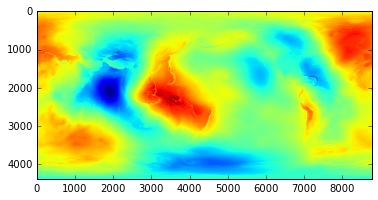

In [5]:
plt.imshow(geoid)

4382 8764


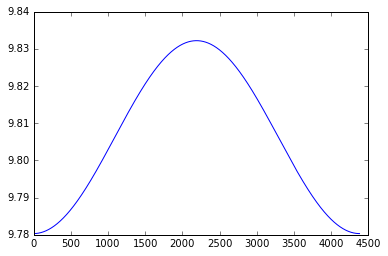

In [6]:
nlat,nlon = geoid.shape
print nlat, nlon
dlat = 180. / nlat
lats = np.linspace(0. + (dlat / 2.), 180. - (dlat / 2.), nlat)
#plt.plot(lats)
normal_gravs = [sht.NormalGravity(lat,GM_earth,omega_earth,a_earth,b_earth) for lat in lats]
ng = np.array(normal_gravs,np.float64)
plt.plot(ng)
#print normal_gravs

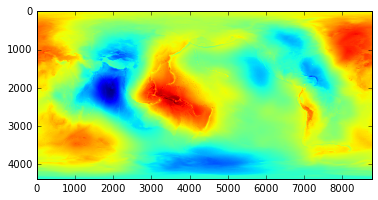

In [7]:
# Brun's formula
T = geoid * ng[:,np.newaxis]
fig = plt.figure()
plt.imshow(T)
#fig.savefig('Timage.png')

In [10]:
# In order to exactly match the Driscoll-Healy convolution theorem details, 
# we'll use the ortho-normalized (norm=4) version
# DON'T FORGET TO CALL WITH SAMPLING=2  !!!!!!!!
T_SH = sht.SHExpandDH(T, lmax_calc=max_degree,norm=4,sampling=2)

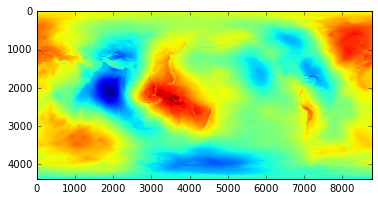

In [11]:
# Sanity check: Do we reproduce T as a grid from the T_SH coefficients?
T_test = sht.MakeGridDH(T_SH,sampling=2,csphase=1,norm=4)
plt.imshow(T_test)

This next function computes the distance from the North Pole on a sphere of radius $R_e$ to all points on a concentric sphere of radius $r_i$. 

Let $\theta$ = the co-latitude (ranging from 0 at the North Pole to $\pi$ at the South Pole).

Let $R_e$ be the radius of an external sphere with center at the origin. (The subscript e for either Earth or external...)

Let $r_i$ be the radius of an internal sphere concentric with the external one, with the vector ${\bf r}_i$ ending at an arbitrary point on the internal sphere. The length $|{\bf r}_i| = r_i$. We also assume that there is some mass located at ${\bf r}_i$. The distribution of these masses over all orientations of ${\bf r}_i$ and for all internal spheres is the object of our tomography. 

Let the $z$ axis be positive through the North Pole.

Let $r_a$ be the distance along the $z$ axis from the North Pole to the base of the vector perpendicular to the $z$ axis that ends at the position vector ${\bf r}_i$. Also let $r_b$ be the (perpendicular) distance from the $z$ axis to the position vector ${\bf r}_i$.

Finally, let $r_{pm}$ be the distance from the North Pole to a mass located at position vector ${\bf r}_i$.

Then $r_a = R_e - r_i \cos \theta$, $r_b = r_i \sin \theta$, and $r_{pm} = \sqrt{r_a^2 + r_b^2} = \sqrt{(R_e - r_i \cos \theta)^2 + (r_i \sin \theta)^2} = \sqrt{R_e^2 + r_i^2 - 2 r_i R_e \cos \theta}$.

In [12]:
def make_Rpm(R_e,r_i,co_lats,shp):
    rpm_1D = np.sqrt(-2.*r_i*R_e*np.cos(co_lats) + R_e**2 + r_i**2 )
    rpm_2D = np.zeros(shp,np.float64)
    rpm_2D[:,:] = rpm_1D[:,np.newaxis]
    
    return rpm_2D

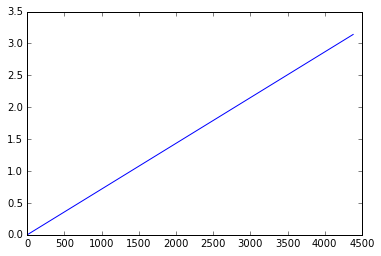

In [13]:
co_lats = np.linspace(0.,np.pi,num=T.shape[0],endpoint=True)
plt.plot(co_lats)

In [37]:
r_inner = 0.99215 *6371000.
rpm_2D = -make_Rpm(R_e = 6371000., r_i = r_inner, co_lats = co_lats, shp = T.shape)
print 6371000. - r_inner

50012.35


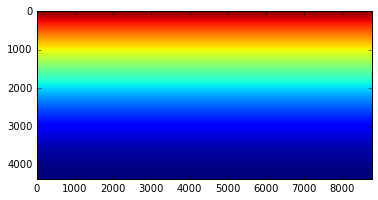

In [38]:
plt.imshow(rpm_2D)

In [39]:
# orthonormalized SH expansion
rpm_2D_SH = sht.SHExpandDH(rpm_2D, norm=4,sampling=2)

In [40]:
print np.max(np.abs(rpm_2D_SH[0,:,0]))
print np.max(np.abs(rpm_2D_SH[1,:,0]))

29999643.89
0.0


In [41]:
kernel =  rpm_2D_SH[0,:,0]
print kernel.shape

(2191,)


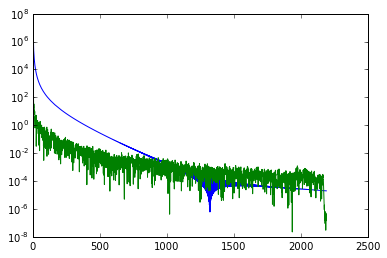

In [42]:
plt.semilogy(np.abs(kernel))
plt.semilogy(np.abs(T_SH[0,:,0]))
#plt.semilogy(np.abs(1./kernel))
#plt.semilogy(np.abs(1./(kernel**2)))


In [43]:
sh_degree = np.arange(T_SH.shape[1])
factor = 2.*np.pi*((1+(2*sh_degree))/(4.*np.pi))**2
convolved = (factor*kernel)[np.newaxis,:,np.newaxis] * T_SH

#convolved = (1./kernel)[np.newaxis,:,np.newaxis] * T_SH


print convolved.shape
#convolved[:,1,1] = 0.

(2, 2191, 2191)


In [44]:
tomo_r1 = sht.MakeGridDH(convolved,sampling=2,csphase=1,norm=4)

In [ ]:
plt.hist(tomo_r1.flat,bins=100,log=True)

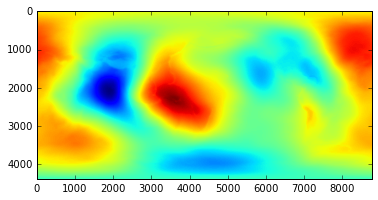

In [45]:
plt.imshow(tomo_r1)

In [28]:
ramp_filter = np.linspace(0.,1.,num=convolved.shape[1],endpoint=True)
ramp_filter_2d = np.sqrt(np.add.outer(ramp_filter*ramp_filter,ramp_filter*ramp_filter))

cone_filter_2d = np.sqrt(np.outer(ramp_filter*ramp_filter,ramp_filter*ramp_filter))

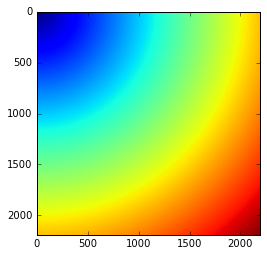

In [30]:
plt.imshow(ramp_filter_2d)

In [31]:
ramp_filter_2d.shape, convolved.shape

((2191, 2191), (2, 2191, 2191))

In [46]:
filtered_convolved = convolved.copy()
filtered_convolved[0,:,:] *= ramp_filter_2d
filtered_convolved[1,:,:] *= ramp_filter_2d

In [47]:
tomo_d50_filtered = sht.MakeGridDH(filtered_convolved,sampling=2,csphase=1,norm=4)

In [48]:
tomo_d100_filtered = sht.MakeGridDH(filtered_convolved,sampling=2,csphase=1,norm=4)

KeyboardInterrupt: 

In [ ]:
plt.hist(tomo_d100_filtered.flat,bins=100,log=True)

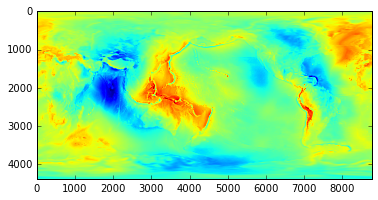

In [50]:
plt.imshow(tomo_d50_filtered)

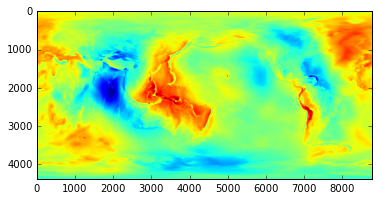

In [49]:
plt.imshow(-tomo_d100_filtered)

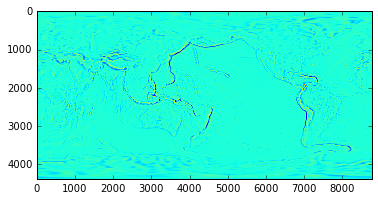

In [51]:
plt.imshow(tomo_d50_filtered + tomo_d100_filtered)

In [1]:
%matplotlib inline
%run GravTomo.py

Loading SHTOOLS documentation




**Old dead code only below here. Mostly preserved for examples of calling routines...**

In [35]:
#d_dr_op = -(2. + np.arange(0,kernel.shape[0]))/(r_inner)
d_dr_op = -(1. + np.arange(1.,kernel.shape[0]+1))/(r_inner)

-0.0429923661583


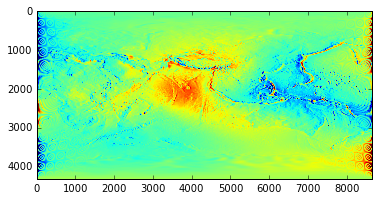

In [36]:
grav_disturbance_SH = d_dr_op * T_SH
grav_disturbance = sht.MakeGridDH(grav_disturbance_SH,sampling=2,csphase=1)
plt.imshow(grav_disturbance,vmin=-0.001,vmax=0.001)
print grav_disturbance.min()

In [23]:
d_dr_convolved = d_dr_op[np.newaxis,:,np.newaxis] * convolved * cone_filter_2d

In [24]:
d_dr_2D = sht.MakeGridDH(d_dr_convolved,sampling=2,csphase=1)

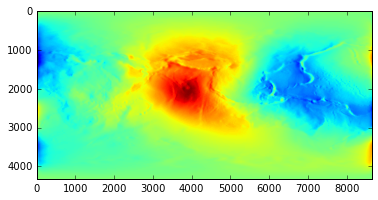

In [25]:
plt.imshow(d_dr_2D)